# Discourse Shift based on Keywords

## Imports and Helpers

In [1]:
import math
import os
import re
import requests
import pandas as pd
from youtube_transcript_api import (
    NoTranscriptFound,
    TranscriptsDisabled,
    VideoUnavailable,
    YouTubeTranscriptApi,
    formatters,
)

api_key = ""
api_url_playlist = "https://www.googleapis.com/youtube/v3/playlistItems"


def get_transcript(video_id: str) -> str:
    ytt_api: YouTubeTranscriptApi = YouTubeTranscriptApi()
    try:
        transcript = ytt_api.fetch(video_id, ["de"])
    except (VideoUnavailable, NoTranscriptFound, TranscriptsDisabled):
        print("Failed to get transcript")
        return ""

    txt_formatter = formatters.TextFormatter()
    return txt_formatter.format_transcript(transcript)


def get_video_ids(playlist_id: str, until: str) -> list[tuple[str, str]]:
    until_int = int(until.replace("-", ""))
    request_params = {
        "part": "contentDetails",
        "playlistId": playlist_id,
        "maxResults": 50,
        "key": api_key,
    }
    next_page_token: str | None = None
    playlist_data: list[tuple[str, str]] = []
    print("Starting YouTube-Api requests...")
    print("Request Count: |", end="")
    while True:
        if next_page_token:
            request_params["pageToken"] = next_page_token
        print("-", end="")
        response = requests.get(
            url=api_url_playlist,
            params=request_params,
            timeout=10,
        )
        response.raise_for_status()

        data = response.json()
        items = data.get("items")
        for item in items:
            content = item.get("contentDetails")
            if not content.get("videoPublishedAt"):
                continue
            published_int = int(content["videoPublishedAt"][:10].replace("-", ""))
            if published_int < until_int:
                print("| Finished.")
                return playlist_data
            playlist_data.append(
                (
                    content["videoId"],
                    content["videoPublishedAt"][:10],
                )
            )
        next_page_token = data.get("nextPageToken")
        if not next_page_token:
            break
    print("| Finished.")
    return playlist_data


def save_transcript(transcript: str, date: str, folder: str):
    year = date[:4]
    try:
        os.mkdir(f"../data/{folder}")
    except FileExistsError:
        pass
    try:
        os.mkdir(f"../data/{folder}/{year}")
    except FileExistsError:
        pass
    with open(
        f"../data/{folder}/{year}/{date}.txt", "w", encoding="utf-8"
    ) as text_file:
        _ = text_file.write(transcript)


def save_transcripts(video_ids: list[tuple[str, str]], folder: str):
    for i, data in enumerate(video_ids):
        if i < 0:  # Adjust to where ip-block has quitted last attempt
            continue
        print(data[1] + " " + str(i))
        t = get_transcript(data[0])
        if len(t) > 0:
            save_transcript(get_transcript(data[0]), data[1], folder)
        else:
            print(f"empty transcript for {data[0]}")


def save_data(video_ids: list[tuple[str, str]], data_folder: str):
    data = pd.DataFrame(video_ids, columns=["video_ids", "date"])
    data.drop_duplicates(subset=["date"], inplace=True)
    data["date"] = pd.to_datetime(data["date"])

    for root, dirs, files in os.walk(f"../data/{data_folder}"):
        for name in files:
            if name.endswith(".txt"):
                with open(os.path.join(root, name), "r", encoding="utf-8") as text_file:
                    transcript = text_file.read().replace("\n", " ")
                    data.loc[data["date"] == name[:-4], "transcript"] = transcript

    data["transcript_length"] = data["transcript"].apply(lambda x: len(str(x)))
    data["transcript_words"] = data["transcript"].apply(
        lambda x: len(str(x).split(" "))
    )

    data.to_pickle(f"../data/{data_folder}/{data_folder}.pkl")
    group_data_by_month(data).to_json(f"../data/{data_folder}/{data_folder}.json", orient="table")


def load_from_pickle(data_folder: str) -> pd.DataFrame:
    return pd.read_pickle(f"../data/{data_folder}/{data_folder}.pkl")


def count_keywords(transcript: str, keywords: list[str]) -> int:
    return len(re.findall("|".join(keywords), transcript, re.IGNORECASE))


def group_data_by_month(data: pd.DataFrame):
    data["date_y-m"] = data["date"].apply(lambda x: x.replace(day=1))
    return data.groupby("date_y-m").agg(
        {"transcript": " ".join, "transcript_words": "sum", "transcript_length": "sum"}
    )


def group_data_by_quarter(data: pd.DataFrame):
    data["date_y-q"] = data["date"].apply(
        lambda x: x.replace(day=1, month=(math.ceil(x.month / 3.0)) * 3)
    )
    return data.groupby("date_y-q").agg(
        {"transcript": " ".join, "transcript_words": "sum", "transcript_length": "sum"}
    )


def group_data_by_year(data: pd.DataFrame):
    data["date_y"] = data["date"].apply(lambda x: x.replace(day=1, month=1))
    return data.groupby("date_y").agg(
        {"transcript": " ".join, "transcript_words": "sum", "transcript_length": "sum"}
    )

## Fetch Data
Since there is no public available archive of transcripts from the governments press conferences we use subtitle data from Youtube videos. 

### Example-Video
Source: https://www.youtube.com/watch?v=1-j58ggnGXM (from 15.01.2024)

In [2]:
date = "2024-01-15"
video_id = "1-j58ggnGXM"

print("Downloading transcript...")
transcript = get_transcript(video_id)
print(f"Found {len(transcript.split(' '))} words.")

print("Saving transcript...")
save_transcript(transcript, date, "example")

Found 8989 words.
Saving transcript...


### Playlist of Bundespresse Konferenzen
Source: https://www.youtube.com/playlist?list=PLuQE_zb4awhV8JxSNeJzUnHskCx0eyjVj

In [ ]:
playlist_id = "PLuQE_zb4awhV8JxSNeJzUnHskCx0eyjVj"
video_ids = get_video_ids(playlist_id, until="2020-01-01")
# save_transcripts(video_ids, "bpk")
save_data(video_ids, "bpk")

## Visualize Data

### Total words

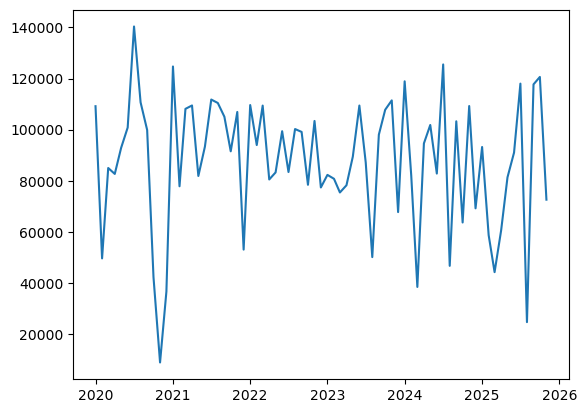

In [4]:
import matplotlib.pyplot as plt

data = load_from_pickle(data_folder="bpk")
grouped_data = group_data_by_month(data)

# Number of total words per month

plt.plot(grouped_data["transcript_words"], label="Words per Month")

### Horizontal Graphs

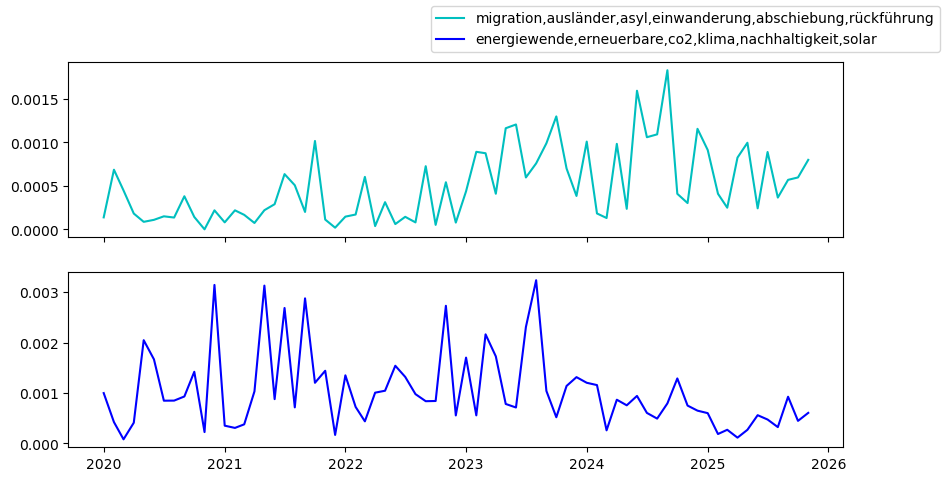

In [3]:
import matplotlib.pyplot as plt

data = load_from_pickle(data_folder="bpk")
grouped_data = group_data_by_month(data)

# Count specific keywords

normalize = True


def calc(x) -> float:
    f = x["transcript_words"] if normalize else 1
    return count_keywords(x["transcript"], keywords) / f


fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

keywords = [
    "migration",
    "ausländer",
    "asyl",
    "einwanderung",
    "abschiebung",
    "rückführung",
]
count_data = grouped_data.apply(calc, axis=1)
axs[0].plot(count_data, label=",".join(keywords), color="c")

keywords = [
    "energiewende",
    "erneuerbare",
    "co2",
    "klima",
    "nachhaltigkeit",
    "solar",
]
count_data = grouped_data.apply(calc, axis=1)
axs[1].plot(count_data, label=",".join(keywords), color="b")

fig.legend()
plt.show()

### Stacked Area Graphs

<Axes: xlabel='date_y-m'>

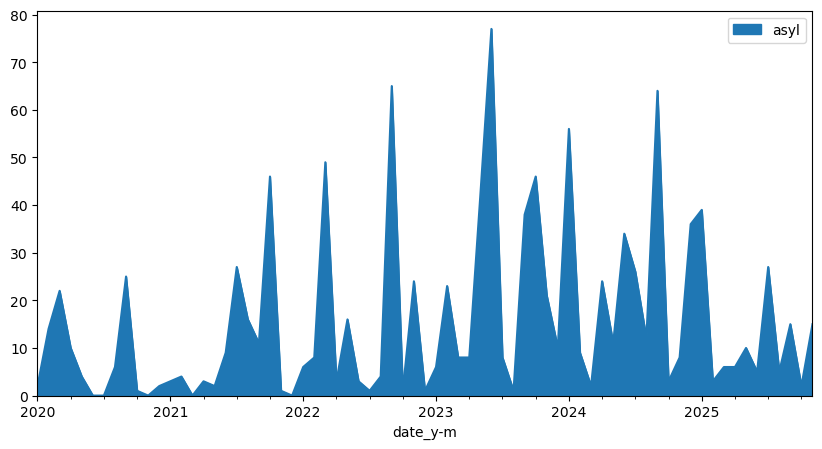

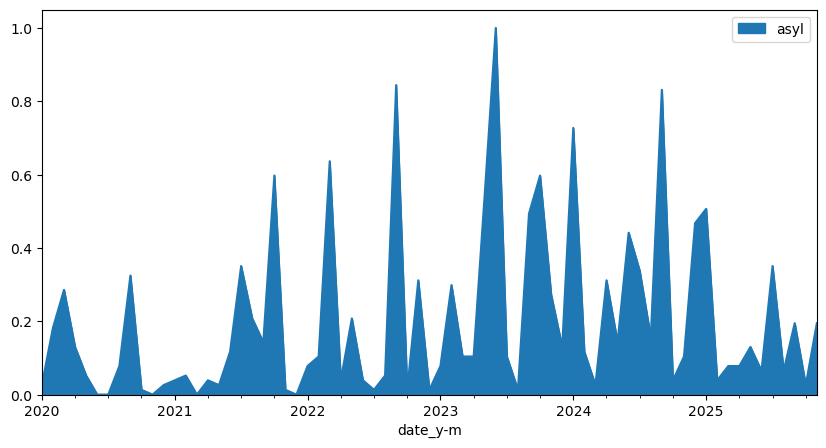

In [6]:
import pandas as pd

data = load_from_pickle(data_folder="bpk")
grouped_data = group_data_by_month(data)

# keywords: list[str] = ["klima(krise|wandel)", "emission", "co2", "erneuerbare", "solar"]
keywords: list[str] = [
    # "migration",
    # "ausländer",
    "asyl",
    # "einwanderung",
    # "abschiebung",
    # "rückführung",
]
data_list = []


for k in keywords:
    # count = grouped_data.apply(lambda x: len(re.findall(k, x["transcript"], re.IGNORECASE)), axis=1).rename(k)
    count = grouped_data.apply(
        lambda x: len(re.findall(k, x["transcript"], re.IGNORECASE)),
        axis=1,
    ).rename(k)
    data_list.append(count)

data_combined = pd.concat(data_list, axis=1)
data_combined.plot.area(figsize=(10,5))
data_relative = data_combined.divide(data_combined.sum(axis=1).max())
data_relative.plot.area(figsize=(10, 5))

#### Signal Processing

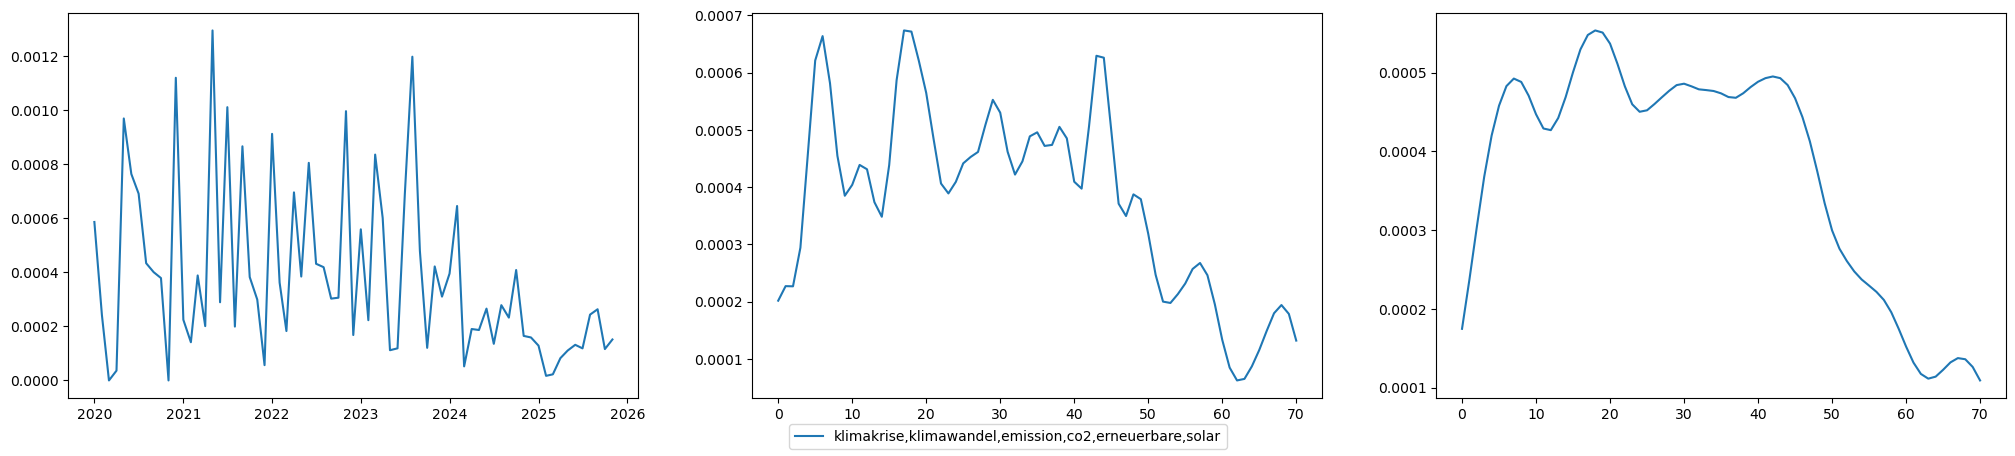

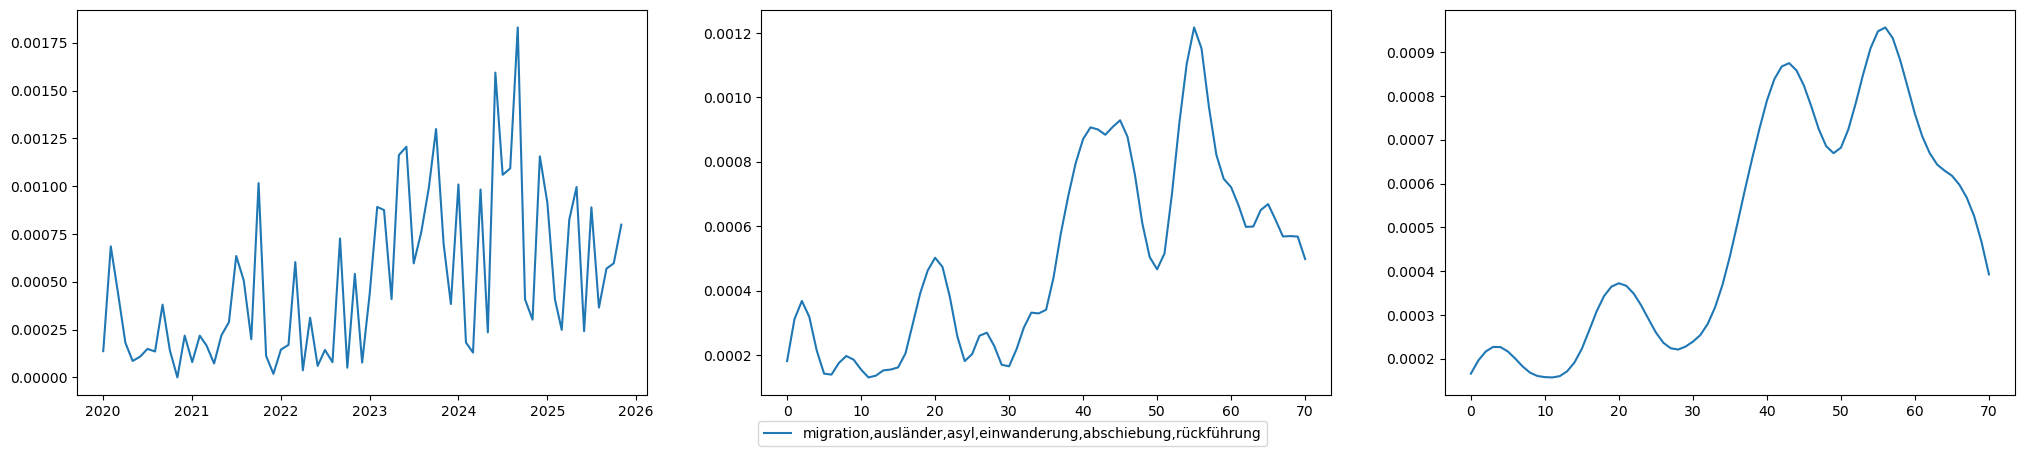

In [2]:
import matplotlib.pyplot as plt
import scipy.signal as sgnl

data = load_from_pickle(data_folder="bpk")
grouped_data = group_data_by_month(data)

# Count specific keywords and convolve

normalize = True


def calc(x) -> float:
    f = x["transcript_words"] if normalize else 1
    return count_keywords(x["transcript"], keywords) / f


fig, axs = plt.subplots(1, 3, figsize=(25, 5))

keywords = ["klimakrise", "klimawandel", "emission", "co2", "erneuerbare", "solar"]
count_data = grouped_data.apply(calc, axis=1)
axs[0].plot(count_data, label=",".join(keywords))

win = sgnl.windows.hann(8)
filtered = sgnl.convolve(count_data, win, mode="same") / sum(win)
axs[1].plot(filtered)

win = sgnl.windows.hann(16)
filtered = sgnl.convolve(count_data, win, mode="same") / sum(win)
axs[2].plot(filtered)


fig.legend(loc="lower center")
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(25, 5))

keywords: list[str] = [
    "migration",
    "ausländer",
    "asyl",
    "einwanderung",
    "abschiebung",
    "rückführung",
]
count_data = grouped_data.apply(calc, axis=1)
axs[0].plot(count_data, label=",".join(keywords))

win = sgnl.windows.hann(8)
filtered = sgnl.convolve(count_data, win, mode="same") / sum(win)
axs[1].plot(filtered)

win = sgnl.windows.hann(16)
filtered = sgnl.convolve(count_data, win, mode="same") / sum(win)
axs[2].plot(filtered)


fig.legend(loc="lower center")
plt.show()

### Toplist Word

In [39]:
from typing import Any


data = load_from_pickle(data_folder="bpk")
grouped_data = group_data_by_month(data)

histBlacklist = ["Frage","Sie","Thema","Herr", "Frau", "Ähm", "Ähm,", "Das", "Und", "Bundesregierung", "Ich", "Ja","Ja,","Dann","Äh", "Die", "Also", "Wir", "Es", "Herrn"]
def toplist(t: str):
    array = t.split()
    list: dict[Any, Any] = {}
    for word in array:
        if word in histBlacklist or not word[:1].isupper():
            continue
        if word in list:
            list[word] = list[word] + 1
        else:
            list[word] = 1
    list = dict(filter(lambda w: w[1] > 10, list.items()))
    list = dict(sorted(list.items(), key=lambda item: item[1], reverse=True))
    print(list)
    return list

grouped_data["toplist"] = grouped_data["transcript"].apply(toplist)
# grouped_data


{}
{}
{}
{}
{}
{}
{}
{}
{}
{'Kanzlerin': 21, 'Bundeskanzlerin': 17, 'Fragen': 15, 'Situation': 15, 'Ihnen': 13, 'Europäischen': 11, 'Deutschland': 11, 'EU': 11}
{}
{}
{}
{}
{}
{}
{}
{}
{'Woche': 20, 'Menschen': 13, 'Lage': 12, 'Tunesien': 12, 'Impfpflicht': 12, 'Afghanistan': 11}
{}
{'Deutschland': 24, 'Bundeskanzlerin': 17, 'Briefwahl': 13, 'Fragen': 12, 'Einsatz': 12, 'Kanzlerin': 11, 'Menschen': 11}
{'Fragen': 18, 'Deutschland': 13, 'Afghanistan': 11}
{}
{}
{'Deutschland': 25, 'Zahlen': 19, 'Woche': 16, 'Fragen': 14, 'RKI': 13}
{}
{}
{'Prozent': 25, 'Energien': 20, 'Deutschland': 18, 'Paket': 12, 'Ausbau': 12, 'Maßnahmen': 12, 'Fragen': 11, 'Ende': 11}
{}
{'Gas': 21, 'Konferenz': 19, 'Ukraine': 13, 'Kohlekraftwerke': 13, 'Unternehmen': 13, 'Freitag': 12, 'Entscheidung': 12, 'Situation': 11}
{'Menschen': 53, 'Euro': 38, 'Inflation': 34, 'Haushalte': 28, 'Einkommen': 22, 'Vorschlag': 19, 'Fragen': 18, 'Milliarden': 18, 'Gas': 18, 'Maßnahmen': 17, 'Deutschland': 17, 'Problem': 16, 'Dan